In [42]:
%pip -q install datasets seaborn wordcloud nltk scikit-learn huggingface_hub


Note: you may need to restart the kernel to use updated packages.


In [43]:
import pandas as pd
import numpy as np
import re
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from wordcloud import WordCloud
from huggingface_hub import hf_hub_download

import nltk
from nltk.stem import PorterStemmer

sns.set_theme(context="notebook", style="whitegrid")
plt.rcParams["figure.dpi"] = 120
nltk.download("punkt", quiet=True)


True

In [44]:
path_syn = hf_hub_download(repo_type="dataset", repo_id="ShenLab/MentalChat16K", filename="Synthetic_Data_10K.csv")
path_int = hf_hub_download(repo_type="dataset", repo_id="ShenLab/MentalChat16K", filename="Interview_Data_6K.csv")

df_syn = pd.read_csv(path_syn)
df_int = pd.read_csv(path_int)

df_syn["origin"] = "synthetic"
df_int["origin"] = "interview"

df = pd.concat([df_syn, df_int], ignore_index=True)[["instruction", "input", "output", "origin"]]
print({"rows": len(df), "columns": df.columns.tolist(), "origin_counts": df["origin"].value_counts().to_dict()})
df.head(3)


{'rows': 16084, 'columns': ['instruction', 'input', 'output', 'origin'], 'origin_counts': {'synthetic': 9774, 'interview': 6310}}


,instruction,input,output,origin
0,You are a helpful mental health counselling as...,I think I might be developing a substance abus...,I'm really glad that you reached out and share...,synthetic
1,You are a helpful mental health counselling as...,Parenting has become such a challenge for me. ...,I can understand how challenging parenting can...,synthetic
2,You are a helpful mental health counselling as...,Intimacy has always been a struggle for me. I ...,I can understand how challenging it must be fo...,synthetic


In [46]:
df["input"] = df["input"].astype(str).str.strip()
df["output"] = df["output"].astype(str).str.strip()
nonempty = (df["input"].str.len() > 0) & (df["output"].str.len() > 0)
df = df[nonempty].copy()
df.drop_duplicates(subset=["input", "output"], inplace=True)
df.reset_index(drop=True, inplace=True)
print({"rows_after_basic_filters": len(df)})


{'rows_after_basic_filters': 16005}


In [47]:
def count_words(text: str) -> int:
    return len(re.findall(r"[A-Za-z']+", text))

df["input_words"] = df["input"].map(count_words)
df["output_words"] = df["output"].map(count_words)

df = df[(df["input_words"] >= 5) & (df["output_words"] >= 5)].copy()
df.reset_index(drop=True, inplace=True)
print({"rows_after_length_filters": len(df)})


{'rows_after_length_filters': 15963}


In [48]:
stemmer = PorterStemmer()
stopwords = set(ENGLISH_STOP_WORDS)
pattern = re.compile(r"[A-Za-z']+")

def normalize(text: str, do_stem: bool = True) -> list[str]:
    tokens = pattern.findall(text.lower())
    tokens = [t for t in tokens if t not in stopwords and len(t) > 2]
    if do_stem:
        tokens = [stemmer.stem(t) if len(t) >= 4 else t for t in tokens]
    return tokens

df["input_tokens"] = df["input"].map(lambda x: normalize(x, True))
df["output_tokens"] = df["output"].map(lambda x: normalize(x, True))
print(df[["input_words", "output_words"]].describe().T)


                count        mean         std   min    25%    50%    75%  \
input_words   15963.0   96.046670   79.092663   7.0   51.0   67.0  100.0   
output_words  15963.0  316.645869  124.307085  35.0  256.0  333.0  385.0   

                 max  
input_words   2673.0  
output_words  1887.0  


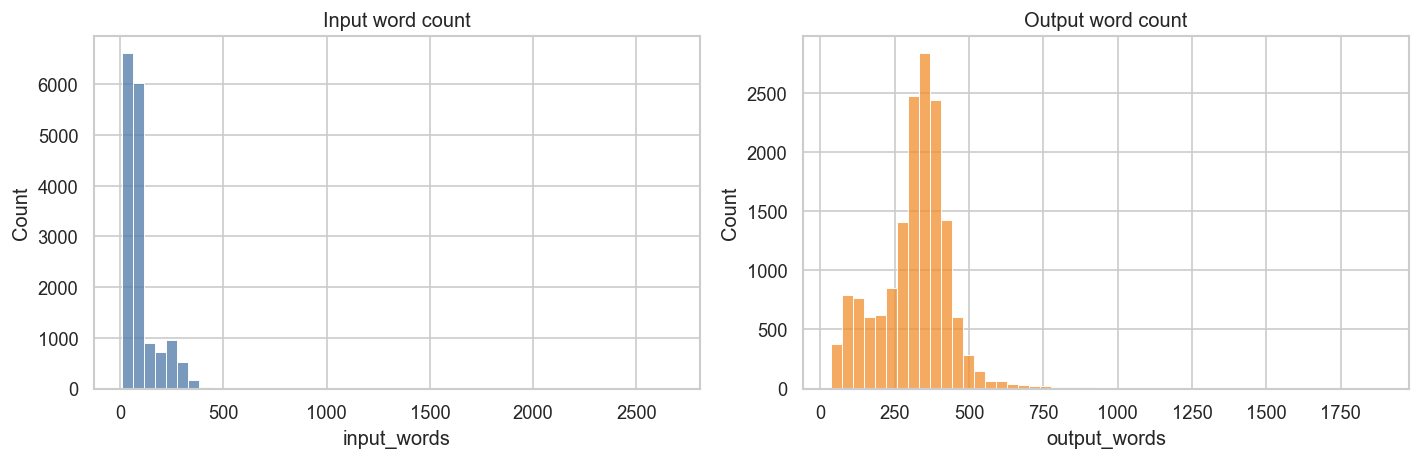

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df["input_words"], bins=50, ax=ax[0], color="#4e79a7")
ax[0].set_title("Input word count")
sns.histplot(df["output_words"], bins=50, ax=ax[1], color="#f28e2c")
ax[1].set_title("Output word count")
plt.tight_layout()
plt.show()


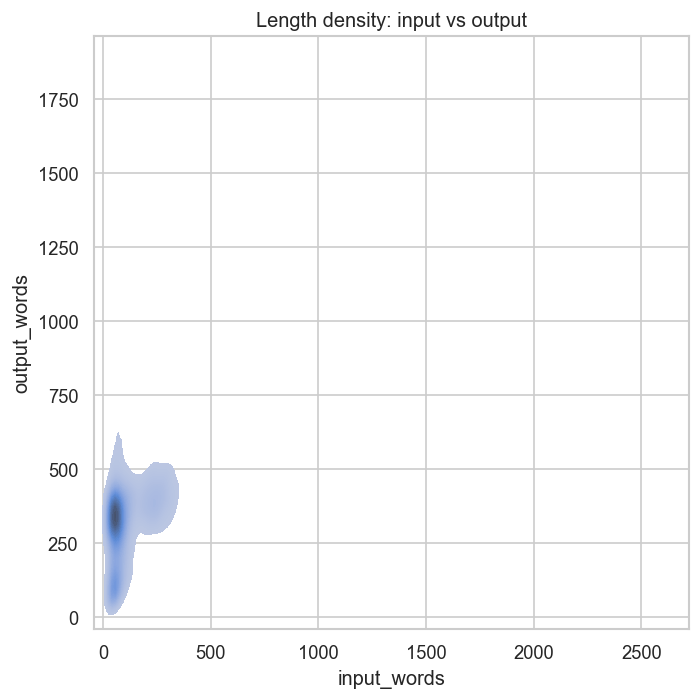

In [50]:
plt.figure(figsize=(6, 6))
sns.kdeplot(x=df["input_words"], y=df["output_words"], fill=True, thresh=0.05, levels=60)
plt.xlabel("input_words")
plt.ylabel("output_words")
plt.title("Length density: input vs output")
plt.tight_layout()
plt.show()


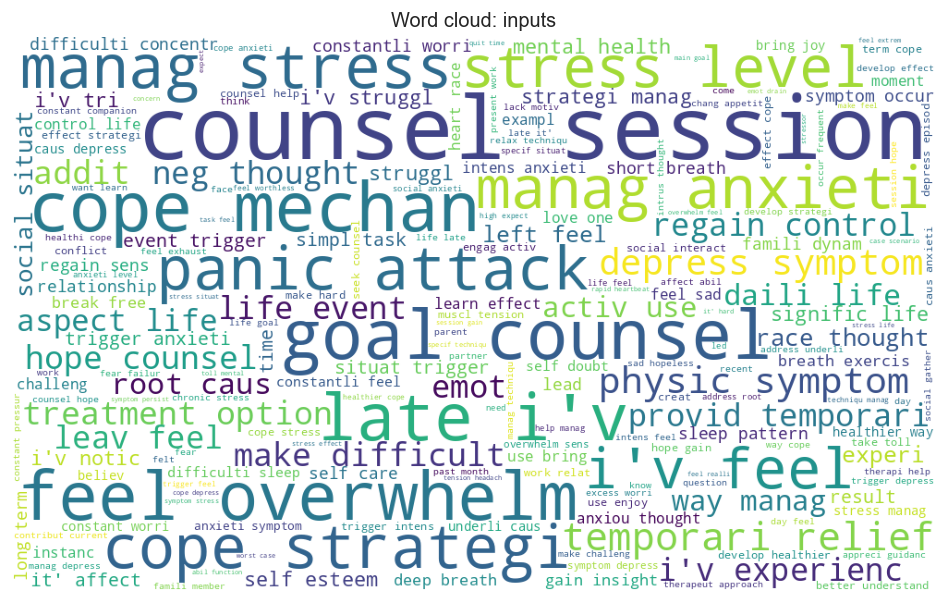

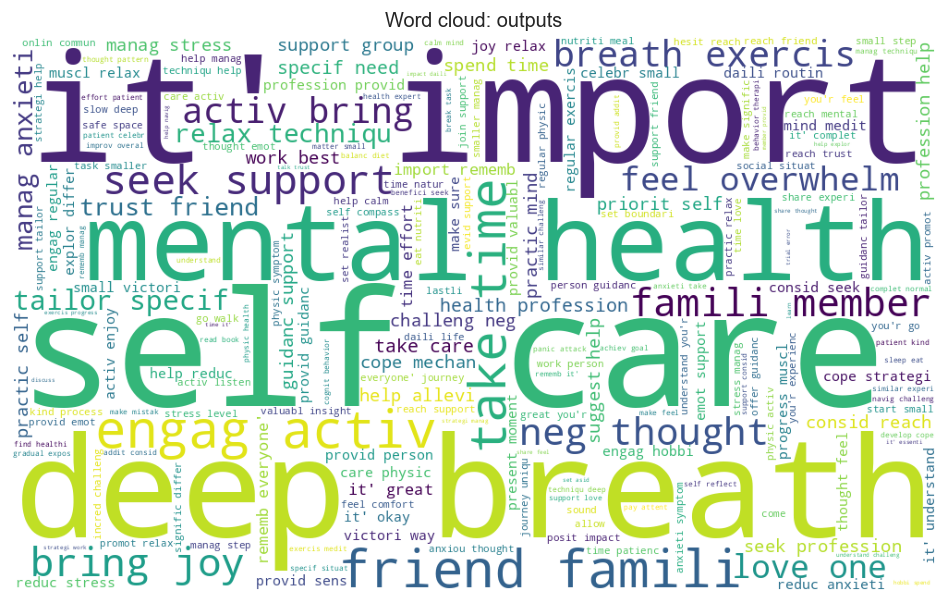

In [51]:
text_in = " ".join(" ".join(toks) for toks in df["input_tokens"])[:3_000_000]
text_out = " ".join(" ".join(toks) for toks in df["output_tokens"])[:3_000_000]

wc_in = WordCloud(width=1000, height=600, background_color="white").generate(text_in)
plt.figure(figsize=(10, 6))
plt.imshow(wc_in)
plt.axis("off")
plt.title("Word cloud: inputs")
plt.show()

wc_out = WordCloud(width=1000, height=600, background_color="white").generate(text_out)
plt.figure(figsize=(10, 6))
plt.imshow(wc_out)
plt.axis("off")
plt.title("Word cloud: outputs")
plt.show()


/opt/homebrew/lib/python3.11/site-packages/seaborn/categorical.py:1281: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(aggregator, agg_var)
/opt/homebrew/lib/python3.11/site-packages/seaborn/categorical.py:1281: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(aggregator, agg_var)


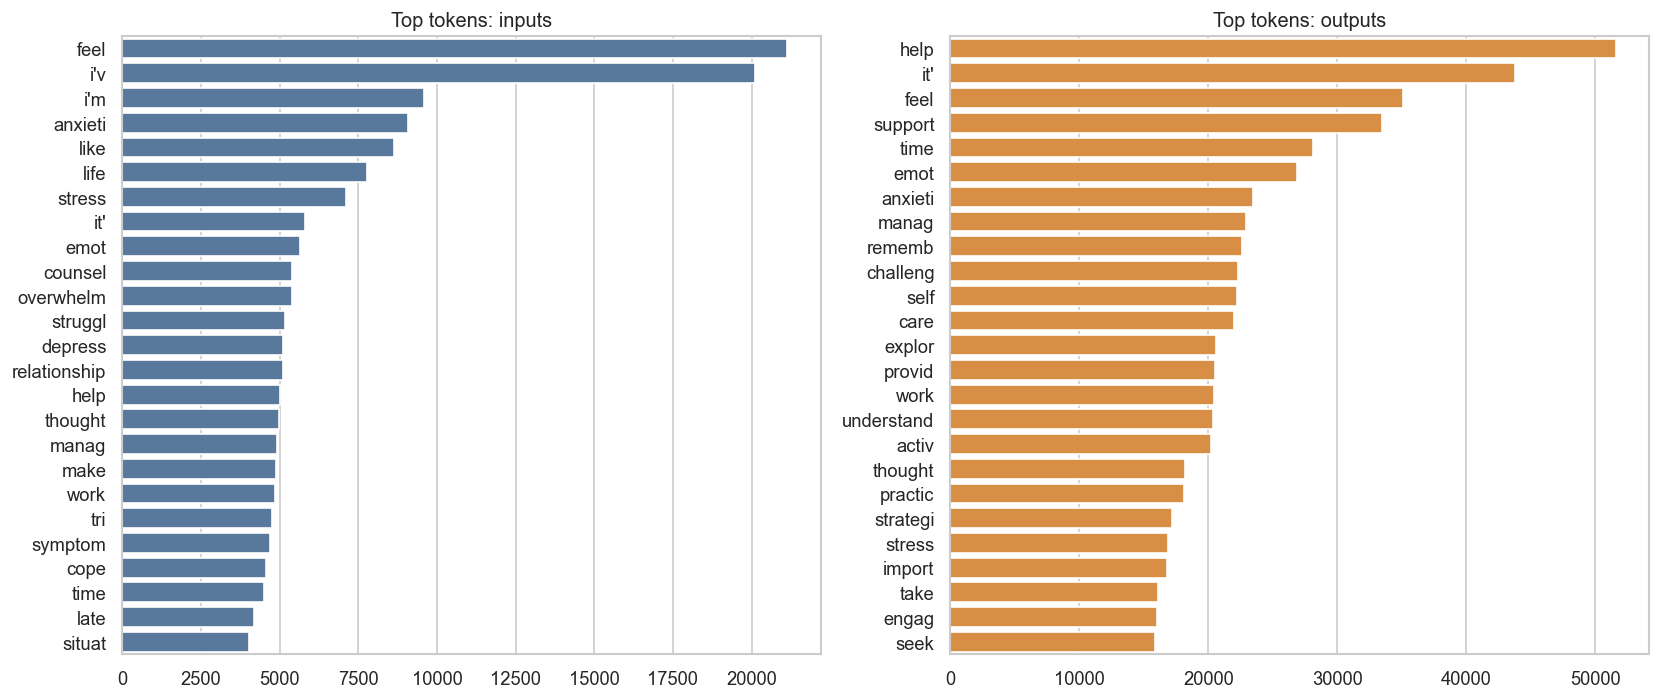

In [52]:
input_flat = [t for toks in df["input_tokens"] for t in toks]
output_flat = [t for toks in df["output_tokens"] for t in toks]

inp_freq = Counter(input_flat)
out_freq = Counter(output_flat)

def top_n(counter: Counter, n: int = 30):
    items = counter.most_common(n)
    keys = [k for k, _ in items]
    vals = [v for _, v in items]
    return keys, vals

keys_inp, vals_inp = top_n(inp_freq, 25)
keys_out, vals_out = top_n(out_freq, 25)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(x=vals_inp, y=keys_inp, ax=ax[0], color="#4e79a7")
ax[0].set_title("Top tokens: inputs")
sns.barplot(x=vals_out, y=keys_out, ax=ax[1], color="#f28e2c")
ax[1].set_title("Top tokens: outputs")
plt.tight_layout()
plt.show()
